<a target="_blank" href="https://colab.research.google.com/github/szilaard/AIT_project/blob/main/transformer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import utils.data
from utils.model import transformer_classifier
from utils.layers import *
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mel')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [6]:
num_samples = X_train.shape[0]

# Generate a random permutation of indices
random_indices = np.random.permutation(num_samples)

# Shuffle X_train and Y_train using the random indices
X_train = X_train[random_indices]
Y_train = Y_train[random_indices]

In [7]:
num_layers=3
d_model=utils.data.n_mfcc_mel
num_heads=3
dff=128
maximum_position_encoding=2048 #utils.data.num_mfcc_vectors_per_segment
n_classes=len(data["mapping"])
n_encoders=3
conv_mode="1d"

In [8]:
model = transformer_classifier(n_encoders, num_layers, d_model, num_heads, dff, maximum_position_encoding, n_classes, conv_mode)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 128)]  0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    1388544     ['input_1[0][0]']                
                                                                                                  
 encoder_1 (Encoder)            (None, None, 128)    1388544     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, None, 128)   0           ['encoder[0][0]',                
 da)                                                              'encoder_1[0][0]']          

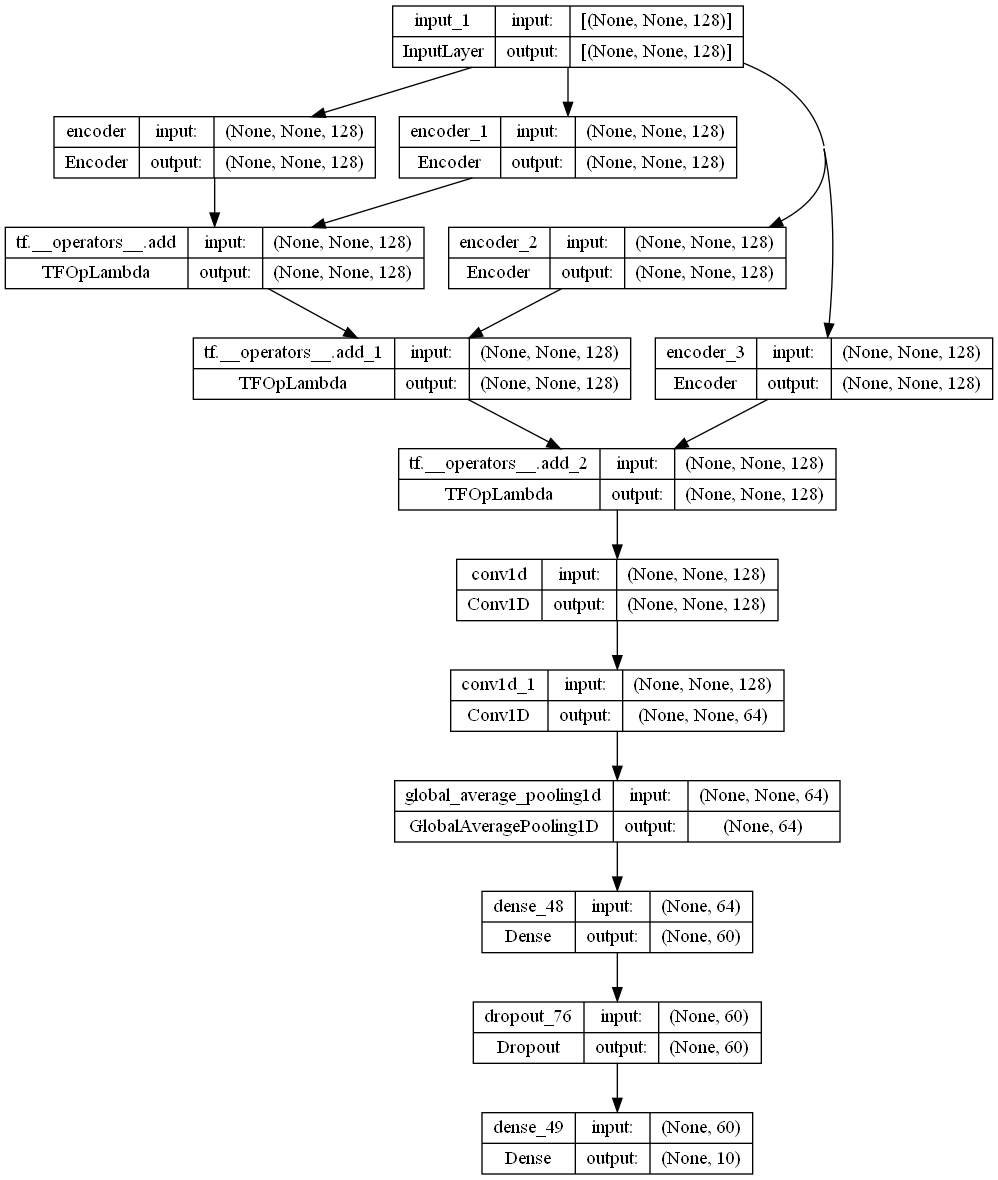

In [9]:
tf.keras.utils.plot_model(model,"model.png", show_shapes = True,)

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [11]:
reduce_o_p = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=20, min_lr=1e-7, mode="min")

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "./models/transformer.h5",
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="auto",
        save_weights_only=True,
    )

In [13]:
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), callbacks=[checkpoint, es])

Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 2.0087 - accuracy: 0.4340
Epoch 1: val_accuracy improved from -inf to 0.47693, saving model to ./models\transformer.h5
219/219 [==============================] - 74s 222ms/step - loss: 2.0087 - accuracy: 0.4340 - val_loss: 1.6056 - val_accuracy: 0.4769
Epoch 2/50
219/219 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.6330
Epoch 2: val_accuracy improved from 0.47693 to 0.49198, saving model to ./models\transformer.h5
219/219 [==============================] - 43s 196ms/step - loss: 1.0962 - accuracy: 0.6330 - val_loss: 2.0355 - val_accuracy: 0.4920
Epoch 3/50
219/219 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.7240
Epoch 3: val_accuracy did not improve from 0.49198
219/219 [==============================] - 41s 187ms/step - loss: 0.8128 - accuracy: 0.7240 - val_loss: 2.1146 - val_accuracy: 0.4905
Epoch 4/50
219/219 [==============================] - ETA: 0s - loss: 

32/32 [==============================] - 4s 59ms/step
              precision    recall  f1-score   support

           0       0.32      0.29      0.30       100
           1       0.89      0.86      0.88        99
           2       0.43      0.64      0.52        99
           3       0.62      0.64      0.63        99
           4       0.69      0.76      0.72        99
           5       0.50      0.60      0.54        99
           6       0.54      0.72      0.62       100
           7       0.80      0.68      0.74       100
           8       0.27      0.06      0.10       100
           9       0.30      0.29      0.30       100

    accuracy                           0.55       995
   macro avg       0.54      0.55      0.53       995
weighted avg       0.54      0.55      0.53       995



[Text(0, 0.5, 'blues'),
 Text(0, 1.5, 'classical'),
 Text(0, 2.5, 'country'),
 Text(0, 3.5, 'disco'),
 Text(0, 4.5, 'hiphop'),
 Text(0, 5.5, 'jazz'),
 Text(0, 6.5, 'metal'),
 Text(0, 7.5, 'pop'),
 Text(0, 8.5, 'reggae'),
 Text(0, 9.5, 'rock')]

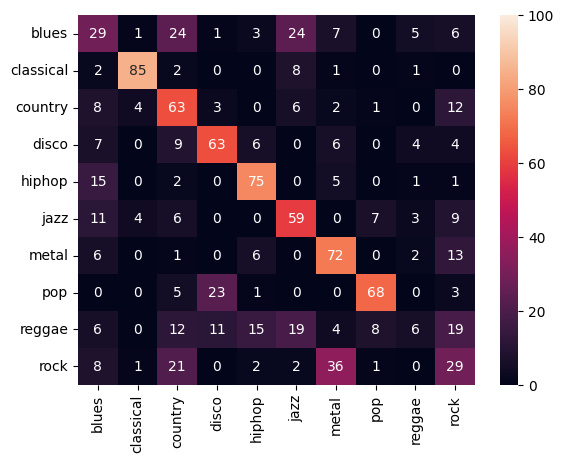

In [14]:
preds = model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
dia= sns.heatmap(conf, annot=True, fmt='d', vmax=100)
dia.set_xticklabels(data["mapping"], rotation=90)
dia.set_yticklabels(data["mapping"], rotation=0)